In [23]:
%matplotlib inline

In [2]:

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle

import os
import pdb
from loren_frank_data_processing import (make_epochs_dataframe,
                                         make_neuron_dataframe)
from src.parameters import (ANIMALS, MAX_N_EXPOSURES, MIN_N_NEURONS)

from scripts.run_by_epoch import clusterless_thetasweeps
from tqdm.auto import tqdm

from scipy.stats import spearmanr, pearsonr
from scipy.signal import hilbert

In [3]:
def bandpassfilter(data, lowcut=5, highcut=11, fs=500):
    """
    band pass filter of the signal
    Created by Zilong, 30/08/2021
    """
    lowcut = 5
    highcut = 11
    order = 5
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype="band")
    filtereddata = signal.filtfilt(b, a, data)

    return filtereddata

In [4]:
def get_sweep_amp_each_theta_cycle(lfp0_in_running, sweeps_dist_in_running):
    """
    get the amplitude of each sweep in each theta cycle
    Input:
        lfp0_in_running: the filtered lfp in running
        sweeps_dist_in_running: the mental distance of each sweep in running
    """
    # get the zero phase index
    zero_phase_index = get_zero_phase(lfp0_in_running)
    
    #if first element in zero_phase_index is 0, remove it
    if zero_phase_index[0] == 0:
        zero_phase_index = zero_phase_index[1:]

    # split the sweeps_dist_in_running according to the zero phase index
    # and extract the largest sweep_dist in each theta cycle
    splits = np.split(sweeps_dist_in_running, zero_phase_index)

    sweep_amp_each_theta_cycle = np.array([np.max(split) for split in splits])

    #print(sweep_amp_each_theta_cycle)
    
    return np.mean(sweep_amp_each_theta_cycle)

### Check the relationship between theta frequency and running speed

In [5]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)
n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))

is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                (epoch_info.exposure <= MAX_N_EXPOSURES) &
                is_animal
                )

In [ ]:
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    #load speed info
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_speed_info.pkl'), 'rb') as f:
        speed = pickle.load(f)
        speed =speed.values
    
    #load lfp
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'{animal}_{day:02d}_{epoch:02d}_data.pkl'), 'rb') as f:
        data = pickle.load(f)
        
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )
    
    # add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
    lfp0 = bandpassfilter(lfp.iloc[:, 0], lowcut=5, highcut=11, fs=500)
    # group the lfp0 into dataframe with time index
    lfp0 = pd.DataFrame(lfp0, index=lfp.index)
    
    #vary speed from 4 to 60 cm/s with interval 4 cm/s
    #for each speed bin, get the mean frequency in lfp0
    
    speed_bins = np.arange(4, 60, 4)
    for s in tqdm(range(len(speed_bins)-1), desc='speed'):
        speed_bin = speed_bins[s]
        speed_bin_next = speed_bins[s+1]
        #print(speed_bin, speed_bin_next)
        
        #get the lfp0 in running
        lfp0_in_running = lfp0[(speed>speed_bin) & (speed<=speed_bin_next)]
        
        #get the mean frequency in lfp0_in_running
        mean_freq = np.mean(np.abs(hilbert(lfp0_in_running.iloc[:,0])))

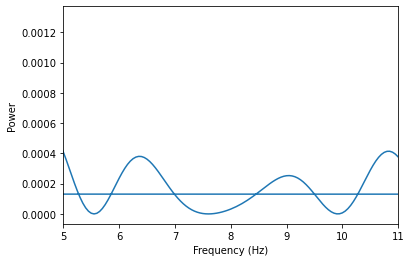

In [53]:
DATA_DIR = '/home/zilong/Desktop/replay_trajectory_paper/Processed-Data'

with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories', f'bon_03_04_speed_info.pkl'), 'rb') as f:
    speed = pickle.load(f)
    speed =speed.values


is_running =  (speed > 4) & (speed <= 30)

#load lfp
with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'bon_03_04_data.pkl'), 'rb') as f:
    data = pickle.load(f)
    
lfp = (
    data["lfps"]
    .reset_index(drop=True)
    .set_index(data["lfps"].index / np.timedelta64(1, "s"))
)

# add band passs filter to lfp.iloc[:,0], using band between 5-11Hz
lfp0 = bandpassfilter(lfp.iloc[:, 0], lowcut=5, highcut=11, fs=500)
# group the lfp0 into dataframe with time index
lfp0 = pd.DataFrame(lfp0, index=lfp.index)

lfp0_in_running = lfp0[is_running]

#compute the power spectrum of lfp0_in_running using fft
lfp0_in_running_fft = np.fft.fft(lfp0_in_running.values[:10000])
frequenties = np.fft.fftfreq(len(lfp0_in_running_fft), 1/500)

# Calculate the squared magnitude (power) of the FFT values
power = np.abs(lfp0_in_running_fft)**2

#Plot the power spectrum in the range of 5-12 Hz
plt.plot(frequenties, power)
plt.xlim(5, 11)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

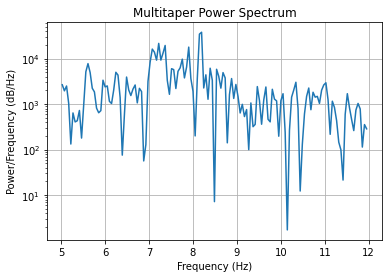

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.signal.windows import dpss

is_running =  (speed > 25) & (speed <= 50)

# Generate a sample signal
fs = 500
signal = lfp.iloc[:, 0][is_running].values

# Define frequency range
freq_min = 5
freq_max = 12

# Create a multitaper window using dpss
window = dpss(len(signal), 2)

# Compute multitaper spectrogram with the correct nperseg
f, t, Sxx = spectrogram(signal, fs, window=window, noverlap=50, nperseg=len(window))

# Extract and plot the power spectrum within the specified frequency range
freq_mask = (f >= freq_min) & (f <= freq_max)
plt.semilogy(f[freq_mask], np.mean(Sxx[freq_mask, :], axis=1))
plt.title('Multitaper Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()


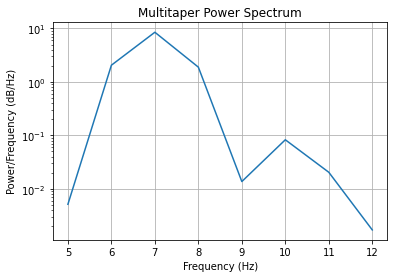

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.signal.windows import dpss

# Generate a sample signal
fs = 1000
t = np.linspace(0, 1, fs, endpoint=False)
signal = 5 * np.sin(2 * np.pi * 7 * t) + 0.5 * np.sin(2 * np.pi * 10 * t) + 0.5 * np.random.randn(len(t))

# Define frequency range
freq_min = 5
freq_max = 12

# Create a multitaper window using dpss
window = dpss(len(signal), 2)

# Compute multitaper spectrogram with the correct nperseg
f, t, Sxx = spectrogram(signal, fs, window=window, noverlap=50, nperseg=len(window))

# Extract and plot the power spectrum within the specified frequency range
freq_mask = (f >= freq_min) & (f <= freq_max)
plt.semilogy(f[freq_mask], np.mean(Sxx[freq_mask, :], axis=1))
plt.title('Multitaper Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()
